In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo

In [5]:
# Read the CSV file
df = pd.read_csv('Cleaned_OnlineRetail.csv')

In [7]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [9]:
# Feature Engineering - Create RFM Metrics
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Recency: Days since the last purchase
recency = df.groupby('CustomerID')['InvoiceDate'].max().apply(lambda x: (snapshot_date - x).days)

# Frequency: Number of unique transactions
frequency = df.groupby('CustomerID')['InvoiceDate'].nunique()

# Monetary: Total spend
monetary = df.groupby('CustomerID')['TotalPrice'].sum()


In [11]:
# Combine into RFM DataFrame
rfm = pd.DataFrame({
    'CustomerID': recency.index,
    'Recency': recency.values,
    'Frequency': frequency.values,
    'Monetary': monetary.values
})


In [13]:
# Data Scaling for Clustering
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

In [41]:
rfm


,CustomerID,Recency,Frequency,Monetary,Cluster,Clusters
0,12346.0,326,1,77183.60,3,4
1,12347.0,2,7,4310.00,0,1
2,12348.0,75,4,1797.24,0,1
3,12349.0,19,1,1757.55,0,1
4,12350.0,310,1,334.40,2,3
...,...,...,...,...,...,...
4333,18280.0,278,1,180.60,2,3
4334,18281.0,181,1,80.82,2,3
4335,18282.0,8,2,178.05,0,1
4336,18283.0,4,16,2045.53,3,4


In [21]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


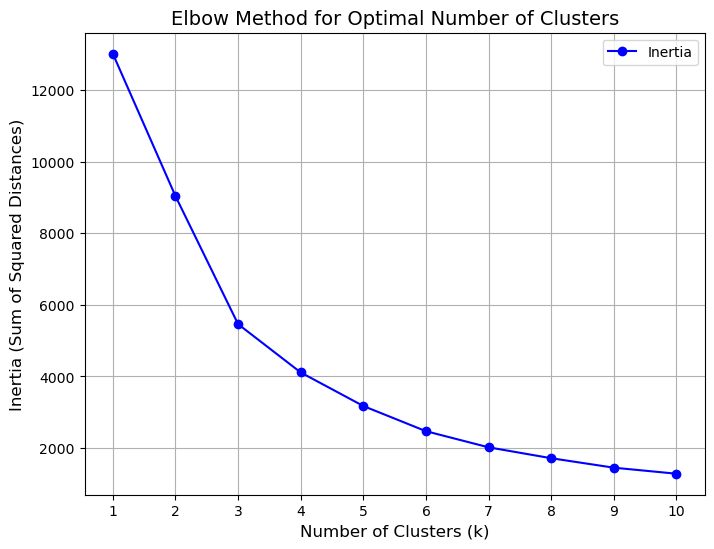

In [23]:

# Initialize an empty list to store the inertia values
inertia_values = []

# Define the range of cluster numbers
k_values = range(1, 11)

# Calculate inertia for each number of clusters
for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia_values.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(k_values, inertia_values, marker='o', linestyle='-', color='b', label='Inertia')
plt.xticks(k_values)  # Ensure x-axis ticks align with the k-values
plt.title('Elbow Method for Optimal Number of Clusters', fontsize=14)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Inertia (Sum of Squared Distances)', fontsize=12)
plt.grid(True)
plt.legend()
plt.show()

In [25]:

# Fit K-Means Model with Optimal Clusters
optimal_k = 4  # Based on the elbow method 
kmeans = KMeans(n_clusters=optimal_k, n_init=10, random_state=42) 
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)


In [39]:
kmeans = KMeans(n_clusters=4, n_init=10, random_state=42)
kmeans.fit(rfm_scaled)
rfm["Clusters"] = kmeans.labels_ + 1

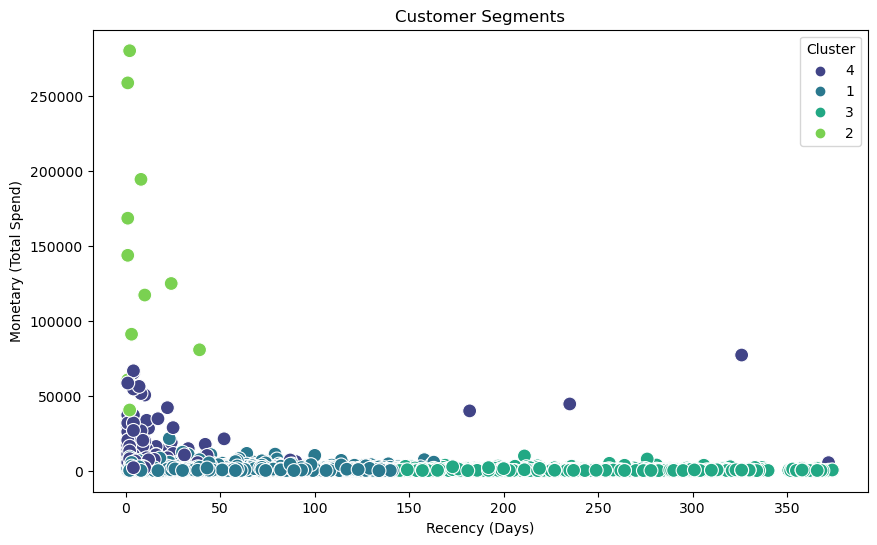

In [77]:
# Assuming the clusters are labeled 0, 1, 2, 3
cluster_mapping = {
    '0': '1',  # Map cluster '0' to '1'
    '1': '2',  # Map cluster '1' to '2'
    '2': '3',  # Map cluster '2' to '3'
    '3': '4'   # Map cluster '3' to '4'
}

# Apply the mapping
rfm['Cluster'] = rfm['Cluster'].map(cluster_mapping)

# Visualize clusters with new labels
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=rfm['Recency'], y=rfm['Monetary'],
    hue=rfm['Cluster'], palette='viridis', s=100
)
plt.title('Customer Segments')
plt.xlabel('Recency (Days)')
plt.ylabel('Monetary (Total Spend)')
plt.legend(title='Cluster')
plt.show()

In [47]:
group = rfm.groupby("Clusters")[["Recency", "Frequency", "Monetary"]].mean()

print(group)

             Recency  Frequency       Monetary
Clusters                                      
1          43.767060   3.651903    1349.473259
2           7.384615  81.692308  127103.643846
3         248.075914   1.552015     478.821313
4          15.371429  21.861905   12424.485476


In [65]:
def func(row):
    if row["Clusters"]==1:
        return "Avg.Cx"
    elif row["Clusters"]==2:
        return 'whales'
    elif row["Clusters"]==3:
        return 'kk'
    else:
        return "Lapsed Cx"

In [70]:
rfm['conditions']=rfm.apply(func, axis=1 )

In [72]:
rfm

,CustomerID,Recency,Frequency,Monetary,Cluster,Clusters,conditions
0,12346.0,326,1,77183.60,3,4,Lapsed Cx
1,12347.0,2,7,4310.00,0,1,Avg.Cx
2,12348.0,75,4,1797.24,0,1,Avg.Cx
3,12349.0,19,1,1757.55,0,1,Avg.Cx
4,12350.0,310,1,334.40,2,3,kk
...,...,...,...,...,...,...,...
4333,18280.0,278,1,180.60,2,3,kk
4334,18281.0,181,1,80.82,2,3,kk
4335,18282.0,8,2,178.05,0,1,Avg.Cx
4336,18283.0,4,16,2045.53,3,4,Lapsed Cx


In [31]:
# Save the results for further analysis
rfm.to_csv("Customer_Segments.csv", index=False)
print("\nCustomer Segmentation Complete. Results saved as 'Customer_Segments.csv'.")


Customer Segmentation Complete. Results saved as 'Customer_Segments.csv'.
